# ONNX Runtime部署-ImageNet1000-摄像头和视频-英文

使用 ONNX Runtime 推理引擎，载入 ImageNet 预训练图像分类 onnx 模型，预测摄像头实时画面。

同济子豪兄：https://space.bilibili.com/1900783

## 注意事项

本代码需在`连接摄像头的本地`运行，不能在云GPU平台运行。

## 导入工具包

In [1]:
import cv2
from cvs import *

from PIL import Image
import time

import onnxruntime

import torch
import torch.nn.functional as F
from torchvision import transforms

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


## 载入 onnx 模型，获取 ONNX Runtime 推理器

In [2]:
ort_session = onnxruntime.InferenceSession('resnet18_imagenet.onnx')

## 载入ImageNet 1000图像分类标签

In [3]:
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['class']

In [4]:
# idx_to_labels

## 图像预处理

In [5]:
# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 初始化摄像头

In [46]:
# 摄像头ID 0-后置 1-前置
Camera_ID = 0

In [1]:
cap = cvs.VideoCapture(Camera_ID)

## 调用摄像头获取一帧画面，预测

### 拍摄一帧画面

In [78]:
img_bgr = cap.read()

In [79]:
img_bgr.shape

(640, 480, 3)

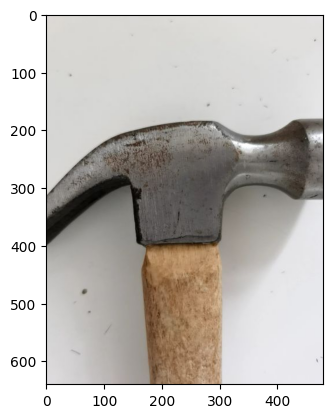

In [80]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

### 画面转成 RGB 的 Pillow 格式

In [81]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR 转 RGB

In [82]:
img_pil = Image.fromarray(img_rgb)

In [83]:
# img_pil

### 预处理

In [84]:
input_img = test_transform(img_pil)
input_tensor = input_img.unsqueeze(0).numpy()

In [85]:
input_tensor.shape

(1, 3, 256, 256)

### ONNX Runtime推理预测

In [86]:
# onnx runtime 输入
ort_inputs = {'input': input_tensor}

# onnx runtime 输出
pred_logits = ort_session.run(['output'], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)

In [87]:
pred_logits.shape

torch.Size([1, 1000])

### 获得预测结果

In [88]:
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [89]:
pred_softmax.shape

torch.Size([1, 1000])

### 解析top-n预测结果的类别和置信度

In [90]:
n = 3
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果

In [91]:
confs = top_n[0].cpu().detach().numpy().squeeze()

In [92]:
confs

array([0.9330863 , 0.05680578, 0.00297255], dtype=float32)

In [93]:
pred_ids = top_n[1].cpu().detach().numpy().squeeze()

In [94]:
pred_ids

array([587, 596, 792])

### 在图像上写英文

In [95]:
for i in range(len(confs)):
    pred_class = idx_to_labels[pred_ids[i]]
    text = '{:<12} {:>.2f}'.format(pred_class, confs[i])
    
    # 写字：图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img_bgr = cv2.putText(img_bgr, text, (50, 80 + 40 * i), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    

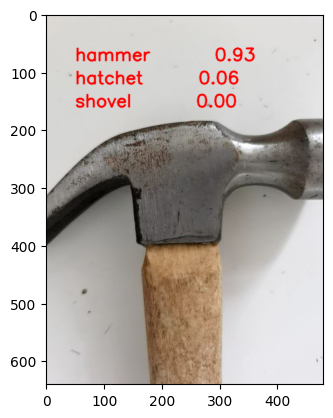

In [96]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 处理单帧画面的函数（英文）

In [55]:
# 处理帧函数
def process_frame(img_bgr):
    
    '''
    输入摄像头拍摄画面bgr-array，输出图像分类预测结果bgr-array
    '''
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    ## 画面转成 RGB 的 Pillow 格式
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB
    img_pil = Image.fromarray(img_rgb) # array 转 PIL
    
    ## 预处理
    input_img = test_transform(img_pil) # 预处理
    input_tensor = input_img.unsqueeze(0).numpy()
    
    ## onnx runtime 预测
    ort_inputs = {'input': input_tensor} # onnx runtime 输入
    pred_logits = ort_session.run(['output'], ort_inputs)[0] # onnx runtime 输出
    pred_logits = torch.tensor(pred_logits)
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算
    
    ## 解析top-n预测结果的类别和置信度
    top_n = torch.topk(pred_softmax, 3) # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析预测类别
    confs = top_n[0].cpu().detach().numpy().squeeze() # 解析置信度
    
    # 在图像上写英文
    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]
        
        # 写字：图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
        text = '{:<12} {:>.2f}'.format(pred_class, confs[i])
        img_bgr = cv2.putText(img_bgr, text, (50, 160 + 40 * i), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)  
    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img_bgr = cv2.putText(img_bgr, 'FPS  '+str(int(FPS)), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    return img_bgr

## 预测摄像头单帧画面

In [56]:
img_bgr = cap.read()

In [57]:
img_bgr = process_frame(img_bgr)

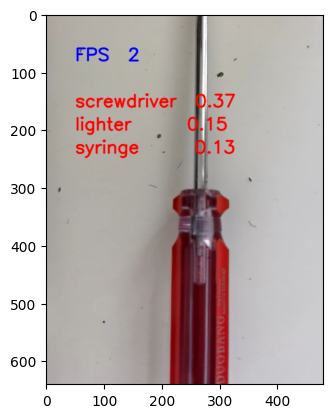

In [58]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 逐帧实时处理手机摄像头拍摄的画面-代码模板

In [ ]:
while True:
    img_bgr = cap.read()
    
    if img_bgr is None:
        continue
        
    img_bgr = process_frame(img_bgr)
    
    cvs.imshow(img_bgr)

> 点击`重启kernel`关闭摄像头

## 视频逐帧处理（模板）

In [38]:
import cv2
import numpy as np
import time
from tqdm import tqdm

# 视频逐帧处理代码模板
# 不需修改任何代码，只需定义process_frame函数即可
# 同济子豪兄 2021-7-10

def generate_video(input_path='videos/robot.mp4'):
    filehead = input_path.split('/')[-1]
    output_path = "out-" + filehead
    
    print('视频开始处理',input_path)
    
    # 获取视频总帧数
    cap = cv2.VideoCapture(input_path)
    frame_count = 0
    while(cap.isOpened()):
        success, frame = cap.read()
        frame_count += 1
        if not success:
            break
    cap.release()
    print('视频总帧数为',frame_count)
    
    # cv2.namedWindow('Crack Detection and Measurement Video Processing')
    cap = cv2.VideoCapture(input_path)
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, fourcc, fps, (int(frame_size[0]), int(frame_size[1])))
    
    # 进度条绑定视频总帧数
    with tqdm(total=frame_count-1) as pbar:
        try:
            while(cap.isOpened()):
                success, frame = cap.read()
                if not success:
                    break

                # 处理帧
                # frame_path = './temp_frame.png'
                # cv2.imwrite(frame_path, frame)
                try:
                    frame = process_frame(frame)
                except:
                    print('报错！', error)
                    pass
                
                if success == True:
                    # cv2.imshow('Video Processing', frame)
                    out.write(frame)

                    # 进度条更新一帧
                    pbar.update(1)

                # if cv2.waitKey(1) & 0xFF == ord('q'):
                    # break
        except:
            print('中途中断')
            pass

    cv2.destroyAllWindows()
    out.release()
    cap.release()
    print('视频已保存', output_path)

In [39]:
generate_video(input_path='video_4.mp4')

视频开始处理 video_4.mp4
视频总帧数为 283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [02:27<00:00,  1.91it/s]

视频已保存 out-video_4.mp4
